# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [x] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [x] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compute theory Eq. 2.13 in draft

In [1]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from numba import jit
import multiprocessing as mp
import healpy as hp
from scipy.linalg import dft
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps

#camb
import camb 
from camb import model, initialpower

# GRFs
import GRF_class as my_GRF

## create GRFs
- set `add_rsd=True' if you want to add RSD

In [2]:
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=False)

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774
beta 0.0
bias 1.0
RSD: False
get power spectrum from CAMB
define k grid
compute amplitudes
Include anisotropies False
compute mu = k_los / |k|
bias 1.0
beta 0.0
Transforming amplitudes to density field


In [3]:
# compute power spectrum with mode counting in spherical shells
k_eff, p0_hat, p2_hat, p4_hat, counts, totcounts = GRF.compute_power_spectrum()
# theory power spectrum anisotropic
p0, p2, p4 = GRF.get_multipoles()


compute power spectrum
134217726.0
134217728
134217728


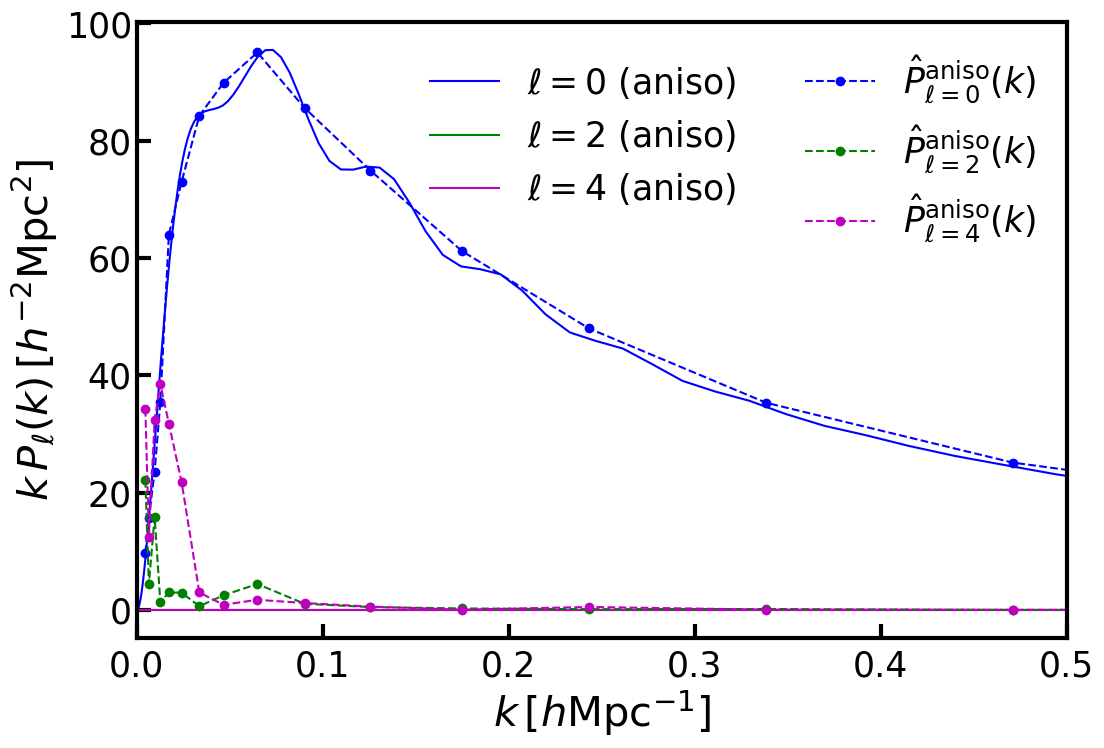

In [4]:
### compare theory to measurement
plt.figure()
plt.plot(GRF.kh_lin, GRF.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(GRF.kh_lin, GRF.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(GRF.kh_lin, GRF.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
plt.plot(k_eff, k_eff*p0_hat, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff, k_eff*abs(p2_hat), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff, k_eff*abs(p4_hat), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()


## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [5]:
# define number of qso drawn from the box
num_qso = int(1e+4)

In [6]:
all_x, all_y, all_z, all_w_rand, all_w_gal, Nskew = GRF.process_skewers(Nskew=num_qso)

N_skew = 9797 / 262144
Displacing box by 5.000e+03


In [7]:
def compute_theta_phi_skewer_start(x,y,z):
    # only compute the Theta, Phi angle for the *first* pixel of the Lya skewer

    xsq = x ** 2.
    ysq = y ** 2.

    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
   
    return theta, phi

In [8]:
all_theta, all_phi = compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:]

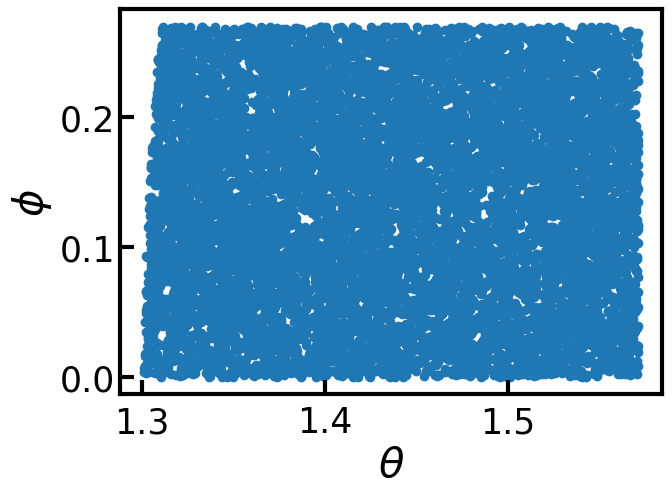

In [9]:
# theta, phi positions of skewers in the sky 
plt.figure(figsize=(7,5));plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

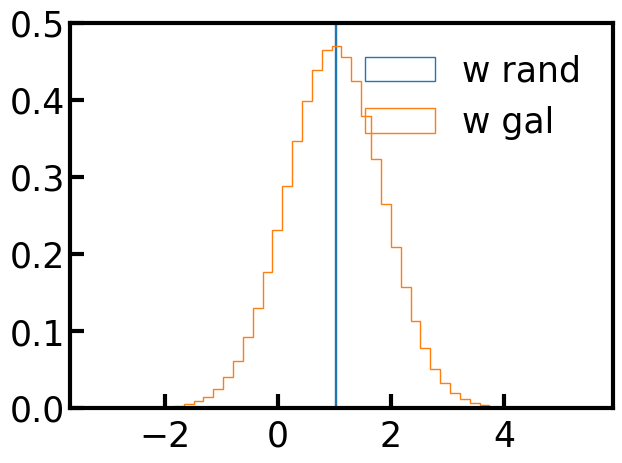

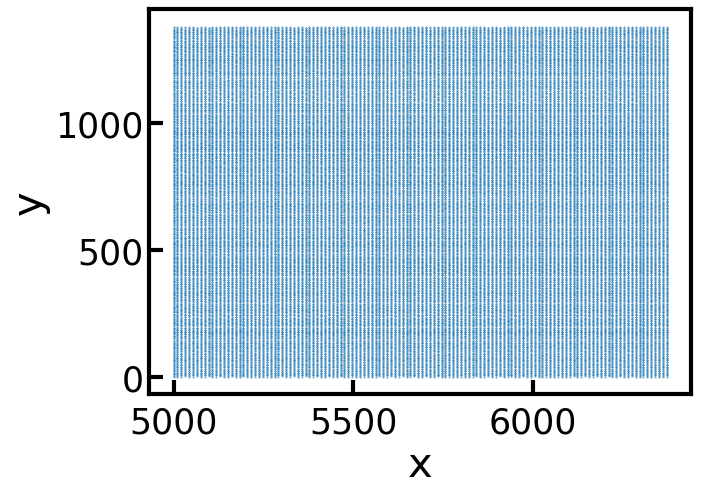

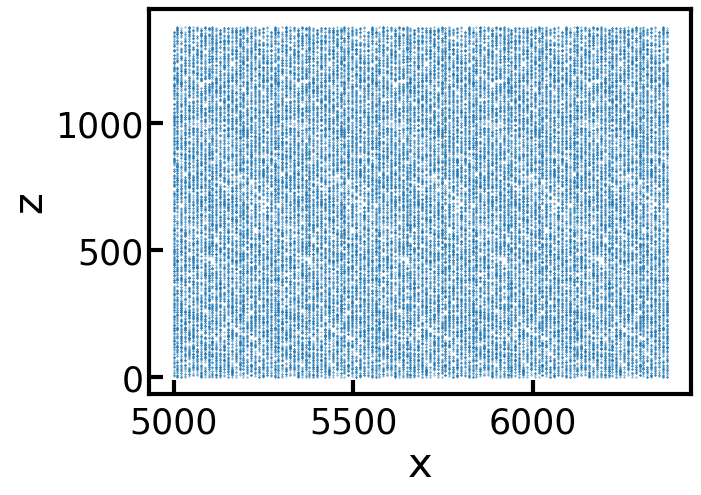

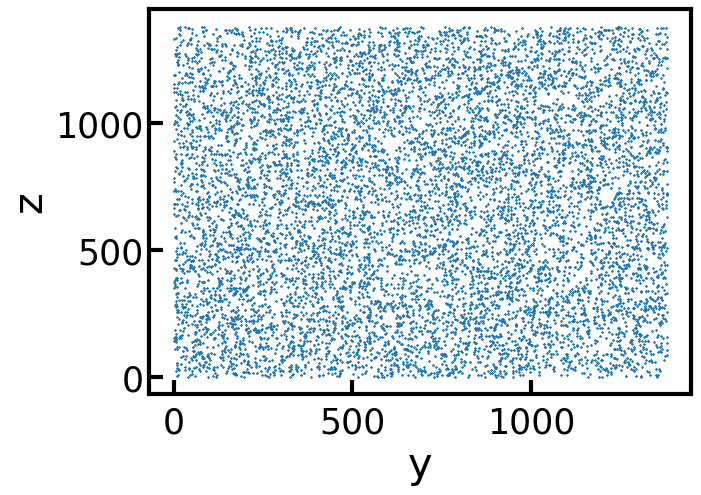

In [10]:
### Plot distribution of weights
plt.figure(figsize=(7,5));
plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_y.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_y.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [12]:
def compute_dft(chi_grid, mask, delta):
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    FT_mat = dft(N)
    # Perform the DFT using matrix multiplication
    FT_mask  = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)

In [13]:
k_arr, FT_mask, FT_delta = compute_dft(chi_grid, all_w_rand, all_w_gal)

### use directSHT to compute $C_{ell}$

In [14]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

env: JAX_ENABLE_X64=True
gpu


In [15]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [16]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta
trand,prand,wrand = all_theta, all_phi, FT_mask

In [17]:
print(wrand.shape)
print(prand.shape)

(9797, 512)
(9797,)


In [18]:
# define index for calculation 
k_idx = 0
# To Do: do this in a loop

In [19]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand[:,k_idx])
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.45831727981567383  seconds.
Reshaping took  0.5838901996612549  seconds.
Precomputing vs took  0.7993776798248291  seconds.
Computing alm's took  1.0976307392120361  seconds.


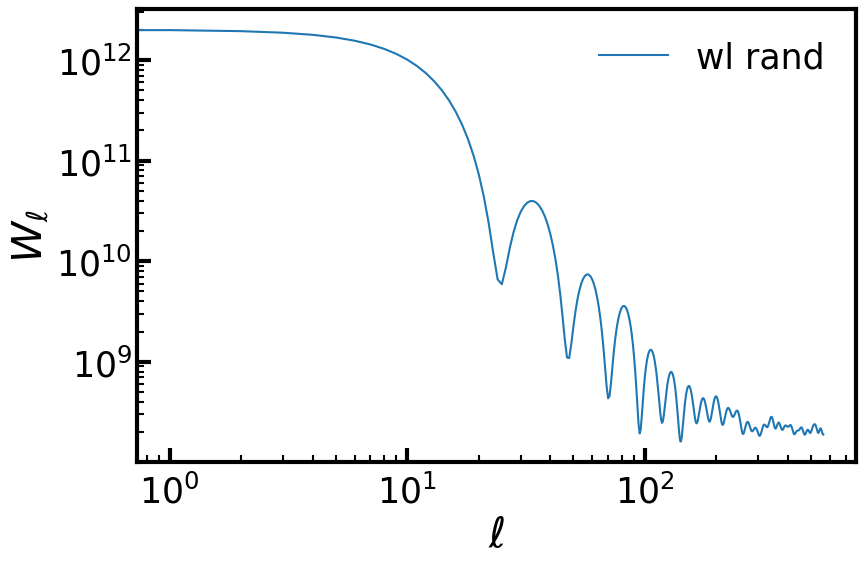

In [21]:
plt.figure(figsize=(9,6))
plt.loglog(wl   ,label='wl rand')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
plt.savefig('./plots/harmonic_window.pdf')

## compute Wigner3j

In [22]:
# if I want to use SHT for the Wigner3j computation
try:
    # Wigner3j code
    from timeit import default_timer as timer
    import fast_Wigner3j as Wigner3j
    print('use rmvd2 Wigner3j computation')

    #iitialize class
    couple_mat = Wigner3j.CoupleMat(Nl+buffer_ells, wl)
    # time execution code
    start = timer()
    coupling_matrix = couple_mat.compute_matrix()
    end = timer()

    # print elapsed time
    print('elapsed time {:1.5f}s'.format(end - start), flush=True)

    %time MD = MaskDeconvolution(Nl+buffer_ells,wl,precomputed_Wigner=coupling_matrix)
except:
    print('use SHT native Wigner3j computation')
    %time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

_fastmath False
_parallel True
_nopython False
use rmvd2 Wigner3j computation
start computation Wigner 3j symbols
elapsed time 0.94653s
Precomputing Wigner 3j symbols...
read in Wigner 3j matrix
CPU times: user 185 µs, sys: 0 ns, total: 185 µs
Wall time: 260 µs

Row sums of Mbl:
[1.00659986 1.00428365 1.00426153 1.00417394 1.00407949 1.00412353
 1.00423574 1.00421268 1.00393216 1.0039339  1.00419584 1.00441683
 1.00451371 1.00412838 1.008592   0.98772718 1.16683054]


### plot coupling matrix and window func

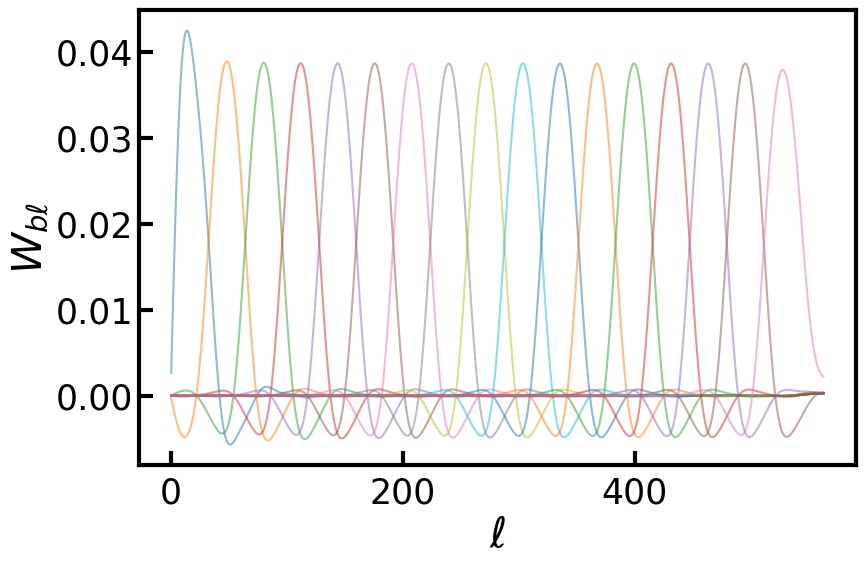

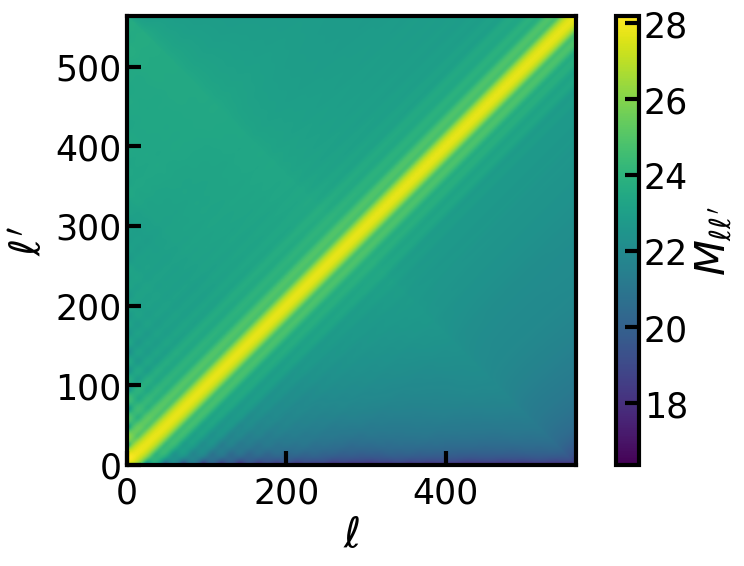

In [25]:
# Plot the matrix:
fig,ax = plt.subplots(1,1, figsize=(9,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
#ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1, figsize=(9,6))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
im = ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

### compute $C_{\ell}(k)$ for different values of $k$

In [26]:
cl_k = []
for k_idx in np.arange(0, 512, 200):
    hdat = sht(tdata,pdata,wdata[:,k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,k_idx])
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    cl_k.append(hdif)
cl_k = np.stack(cl_k)

Sorting & digitizing took  0.0026085376739501953  seconds.
Reshaping took  0.02613973617553711  seconds.
Precomputing vs took  0.23321080207824707  seconds.
Computing alm's took  0.7228672504425049  seconds.
Sorting & digitizing took  0.0021924972534179688  seconds.
Reshaping took  0.024228811264038086  seconds.
Precomputing vs took  0.026305198669433594  seconds.
Computing alm's took  0.42793703079223633  seconds.
Sorting & digitizing took  0.0023317337036132812  seconds.
Reshaping took  0.02424025535583496  seconds.
Precomputing vs took  0.026480436325073242  seconds.
Computing alm's took  0.43128323554992676  seconds.
Sorting & digitizing took  0.0023894309997558594  seconds.
Reshaping took  0.024566173553466797  seconds.
Precomputing vs took  0.02678847312927246  seconds.
Computing alm's took  0.43744611740112305  seconds.
Sorting & digitizing took  0.002341747283935547  seconds.
Reshaping took  0.025323152542114258  seconds.
Precomputing vs took  0.027640104293823242  seconds.
Com

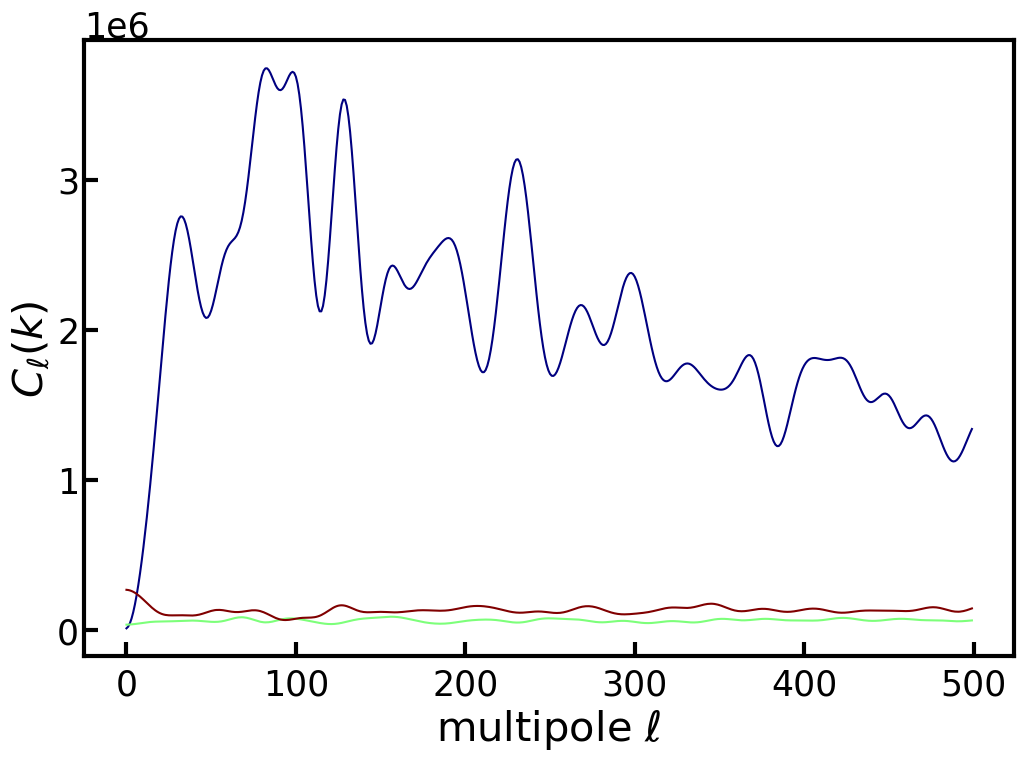

In [27]:
n = len(cl_k)
colors = plt.cm.jet(np.linspace(0,1,n))

for k_idx in range(len(cl_k)):
    plt.plot(np.arange(sht.Nell), cl_k[k_idx],color=colors[k_idx])

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [28]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata[:,k_idx])
# Do the same for the randoms.
hran = sht(trand,prand,wrand[:,k_idx])
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
#print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))

Sorting & digitizing took  0.0024061203002929688  seconds.
Reshaping took  0.024747133255004883  seconds.
Precomputing vs took  0.02721691131591797  seconds.
Computing alm's took  0.39927101135253906  seconds.
Sorting & digitizing took  0.00223541259765625  seconds.
Reshaping took  0.02409648895263672  seconds.
Precomputing vs took  0.026358366012573242  seconds.
Computing alm's took  0.41324663162231445  seconds.


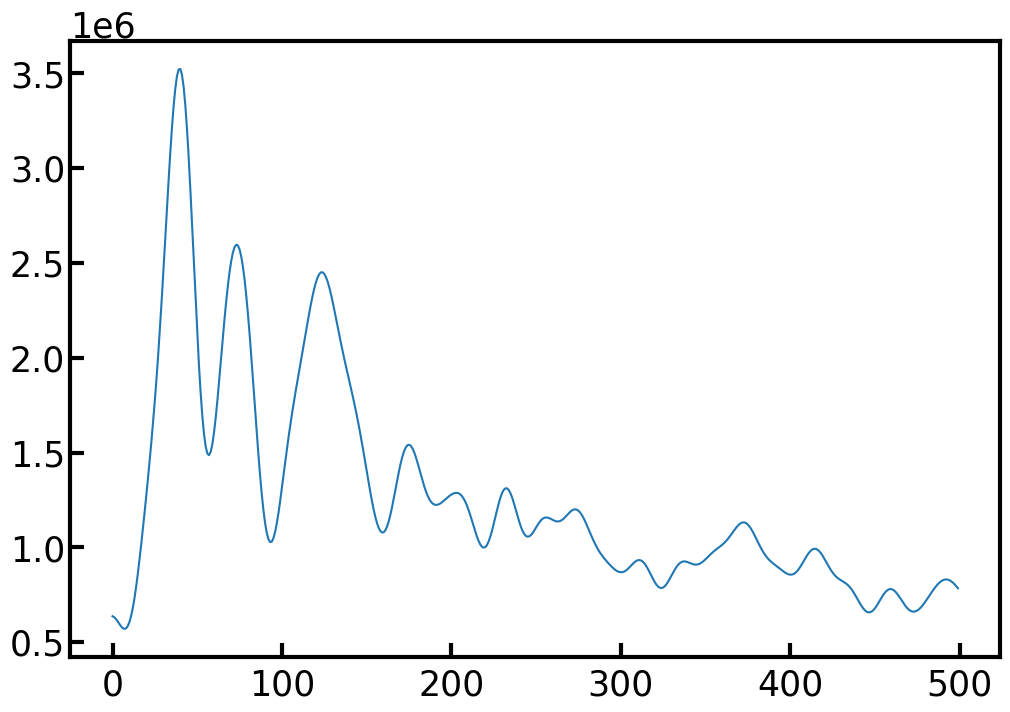

In [29]:
plt.plot(hdif,label='hdif')

In [30]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [31]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[5.97411995e-08 6.73524625e-08 5.81502497e-08 4.21810259e-08
 3.67253607e-08 3.78685177e-08 3.85237652e-08 2.68095656e-08
 2.61725079e-08 3.72713215e-08 2.94246024e-08 2.65302099e-08
 2.37186043e-08]


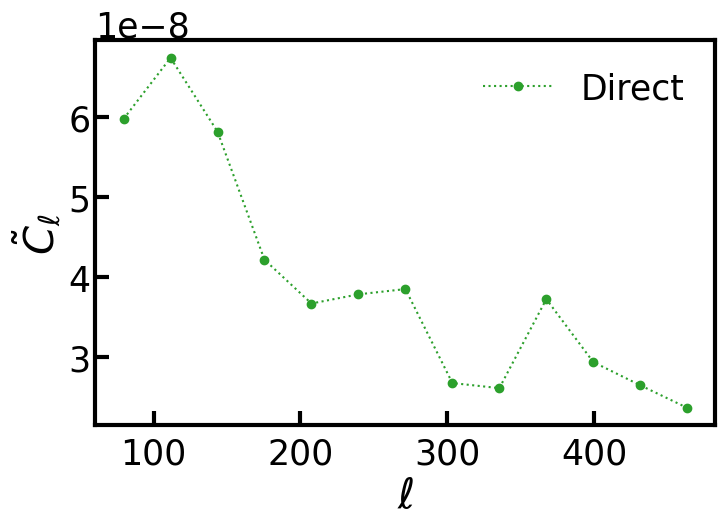

In [32]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
# clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
# ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')


# compute theory power spectrum 
$$\Large  C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$
Let's compute each element separately and then we'll put it all together
- Let's rewrite this $$\sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') = \sum_{j} \widetilde{K}_j^\star(k-k') \left(\sum_kP_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_k(k-k')\right)$$
- [x] we use the definition of $$ F_{\ell L \lambda} = \frac{(2L+1)(2\lambda+1)}{(4\pi)^2} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 $$

In [36]:
from scipy.special import eval_legendre
from scipy.integrate import quad

def F_ell_L_lambda(ell, L, lambda_):
    # Compute the prefactor
    prefactor = (2*L + 1) * (2*lambda_ + 1) / (4 * np.pi)**2
    
    # Compute the Wigner 3-j symbol
    wigner_3j_value = MD.w3j000(ell, L, lambda_)**2
    
    # Compute the final value of F_{ell L lambda}
    F_value = prefactor * wigner_3j_value
    
    return float(F_value)

In [34]:
# the r_ij is cancelling from the cos(theta)
# \hat{n}_j*\hat{n}_k:
nhat = np.column_stack([np.sin(tdata)*np.cos(pdata), np.sin(tdata)*np.sin(pdata), np.cos(tdata)])

In [39]:
qso_j = 0
#qso_k = 10
#for qso_i in range(Nskew):
# compute K_j * K_k vector for one qso_idx and *all* qso_k
#kjkk = FT_mask[qso_j,:]*FT_mask

In [40]:
lambda_idx=0

In [41]:
#np.einsum('ik,jk->ijk',FT_mask, FT_mask)

In [93]:
def int_leg(lambda_idx, k_idx=k_idx, Nskew=Nskew, FT_mask=FT_mask, nhat=nhat):
    total_sum = 0.0
    for qso_j in range(Nskew):
        # Compute K_j * K_k vector for one qso_idx and *all* qso_k
        kjkk = FT_mask[qso_j, k_idx] * FT_mask[:, k_idx]
        # Computation of cos_theta for qso_j and *all* qso_k
        cos_theta_njnk = np.dot(nhat[qso_j], nhat.T)
        # Sum over all pairs qso_j and qso_k
        total_sum += np.sum(eval_legendre(lambda_idx, cos_theta_njnk) * kjkk)
    return total_sum

In [ ]:
cos_theta_njnk = np.outer(nhat, nhat)

In [ ]:
cos_theta_njnk.shape

In [ ]:
qso_j =0
lambda_idx=1
cos_theta_njnk = np.outer(nhat, nhat)
FT_mask @ eval_legendre(lambda_idx, cos_theta_njnk))

In [ ]:
def int_leg_anton(lambda_idx):
    total_sum = 0.
    for qso_j in range(Nskew):
        # Compute K_j * K_k vector for one qso_idx and *all* qso_k
        kjkk = FT_mask[:, k_idx]
        # Computation of cos_theta for qso_j and *all* qso_k
        cos_theta_njnk = np.dot(nhat[qso_j], nhat.T)
        # Sum over all pairs qso_j and qso_k
        total_sum += np.sum(eval_legendre(lambda_idx, cos_theta_njnk) * kjkk)
        total_sum *= FT_mask[qso_j, :]
    return total_sum    

In [ ]:
FT_mask

In [86]:
%%timeit 
np.dot(eval_legendre(lambda_idx, cos_theta_njnk),kjkk)

3.2 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
%%timeit
np.sum(eval_legendre(lambda_idx, cos_theta_njnk) * kjkk)

2.49 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# think of a way to store 3 values n+1, n, n-1 and iterate over all of them 
#recurrence relation 

def compute_leg(n, x):
    if n == 0: return 0
    if n == 1: return x
    return ((2.*n+1.)*x)/(n+1.)

In [81]:
res= int_leg(0, k_idx=k_idx, Nskew=Nskew, FT_mask=FT_mask, nhat=nhat)

In [82]:
res

1.3260234329060093e-17

In [73]:
lambda_idx=10

In [74]:
eval_legendre(lambda_idx, cos_theta_njnk).shape

(102498,)

In [75]:
%time kjkk = FT_mask[qso_j, k_idx] * FT_mask[:, k_idx]
%time cos_theta_njnk = np.dot(nhat[qso_j], nhat.T)
%time eval_legendre(lambda_idx, cos_theta_njnk)
%time np.sum(eval_legendre(lambda_idx, cos_theta_njnk) * kjkk)


CPU times: user 1.35 ms, sys: 580 µs, total: 1.93 ms
Wall time: 1.23 ms
CPU times: user 0 ns, sys: 3.45 ms, total: 3.45 ms
Wall time: 211 µs
CPU times: user 8.27 ms, sys: 86.9 ms, total: 95.2 ms
Wall time: 3.08 ms
CPU times: user 15.1 ms, sys: 83.6 ms, total: 98.7 ms
Wall time: 3.19 ms


2.07508957611553e-23

In [ ]:
plt.

In [58]:
chi_bar = 1.

def Power_spectrum(kh_par, ell, chi):
    kh = np.sqrt(kh_par**2 + (ell/(chi))**2)
    return GRF.plin(kh)

def Cell(l, k_min, k_max):
    def integrand(kint):
        # pk_chi2 = Power_spectrum(kh_par=0, ell=l, chi=chi)/(chi**2)
        pk_chi2 = Power_spectrum(kh_par=kint, ell=l, chi=chi_bar)/(chi**2)*int_leg(lambda_idx, k_idx=k_idx,)
        return pk_chi2/(2.*np.pi)
    return quad(integrand, k_min, k_max)[0]

#Limber's approximation
kh = np.linspace(1e-4, 10, 5000)
# 2-500 in bins of 10 after 100 
ell_range = np.concatenate([np.arange(2, 100), np.arange(100, 510, 10)])
ell_range = np.concatenate([np.arange(2, 100, 10)])
#Cell = np.array([Cell(li, 0.1, 1000) for li in ell_range])

[]

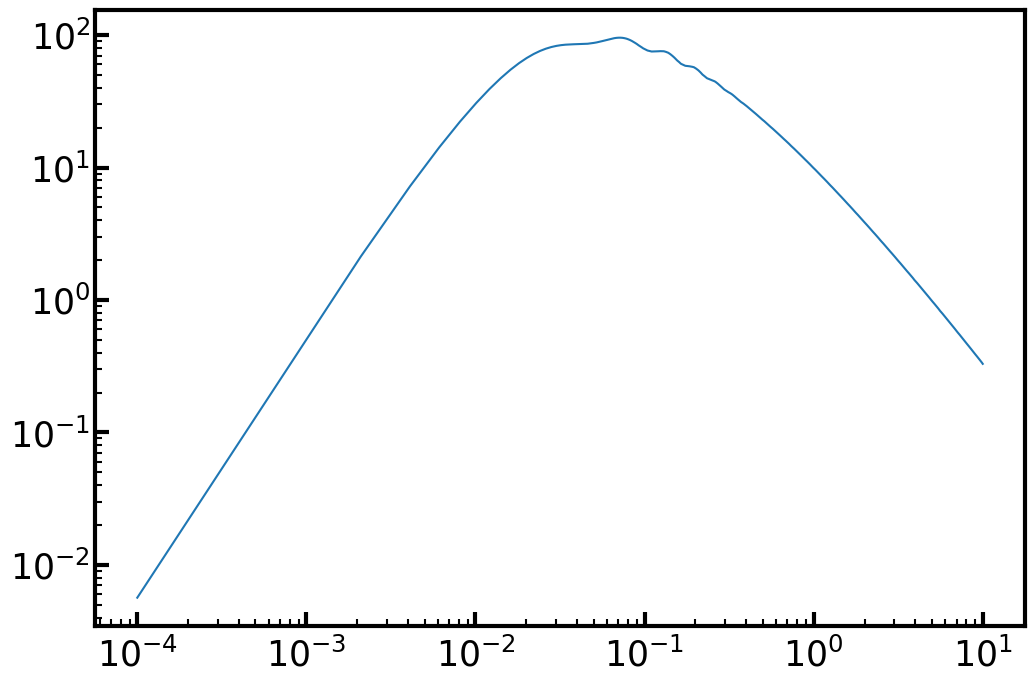

In [59]:
plt.plot(kh, kh*GRF.plin(kh));plt.loglog()

In [51]:
Cl_int = 0.
for ell_idx in ell_range:
    for L in range(10):
        for lambda_ in range(10):
            Cl_int += F_ell_L_lambda(ell_idx, L, lambda_)*Cell(ell_idx, 0.1, 1000)


KeyboardInterrupt



In [ ]:
plt.plot(ell_idx, Cl_int)